In [ ]:
import keras
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("bnf_10_year_data.csv")
df = df.sort_values('Date')
df.set_index("Date", inplace=True)
df

,Close
Date,
2009-05-26,6851.10
2009-05-27,7215.20
2009-05-28,7338.60
2009-05-29,7416.00
2009-06-01,7364.05
...,...
2021-10-12,38521.50
2021-10-13,38635.75
2021-10-14,39340.90


In [3]:
train, test = df.iloc[:-100,:], df.iloc[-100:,:]

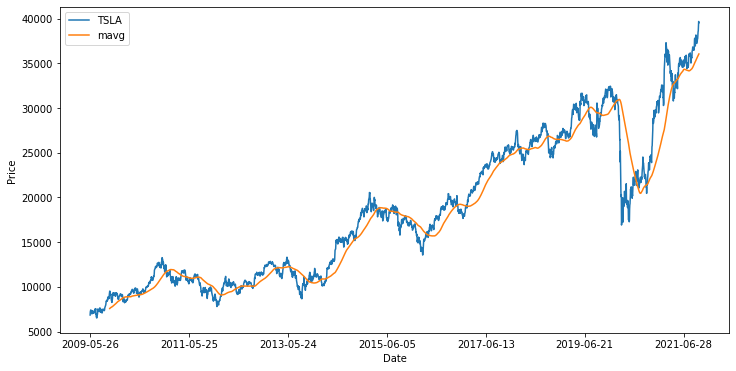

In [4]:
# Rolling mean
close_px = df['Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [5]:
# Create train set of adj close prices data:
train_data = train.loc[:,'Close'].to_numpy()
print(train_data.shape) # 2978

(2978,)


In [6]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [7]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# Create the data to train our model on:
time_steps = 20
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 1))

print(X_train.shape)

(2958, 20, 1)


In [9]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print()
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[6851.1 ]
 [7215.2 ]
 [7338.6 ]
 [7416.  ]
 [7364.05]
 [7343.2 ]
 [7262.3 ]
 [7349.9 ]
 [7343.3 ]
 [6975.05]
 [7185.75]
 [7338.95]
 [7251.65]
 [7083.1 ]
 [7081.2 ]
 [7274.15]
 [7081.75]
 [7081.15]
 [7223.55]
 [7229.55]]


y_train: [[7091.3]]



In [10]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 50, batch_size = 10, validation_split=.30)

Epoch 1/50
207/207 [==============================] - 50s 36ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 2/50
207/207 [==============================] - 4s 20ms/step - loss: 7.5510e-04 - val_loss: 0.0010
Epoch 3/50
207/207 [==============================] - 4s 20ms/step - loss: 5.2912e-04 - val_loss: 9.0986e-04
Epoch 4/50
207/207 [==============================] - 4s 20ms/step - loss: 5.3761e-04 - val_loss: 0.0019
Epoch 5/50
207/207 [==============================] - 4s 21ms/step - loss: 5.3560e-04 - val_loss: 8.6704e-04
Epoch 6/50
207/207 [==============================] - 4s 20ms/step - loss: 3.8346e-04 - val_loss: 7.8040e-04
Epoch 7/50
207/207 [==============================] - 4s 20ms/step - loss: 3.7757e-04 - val_loss: 8.9656e-04
Epoch 8/50
207/207 [==============================] - 4s 20ms/step - loss: 3.6398e-04 - val_loss: 7.6333e-04
Epoch 9/50
207/207 [==============================] - 4s 20ms/step - loss: 3.7790e-04 - val_loss: 0.0012
Epoch 10/50
207/207 [=================

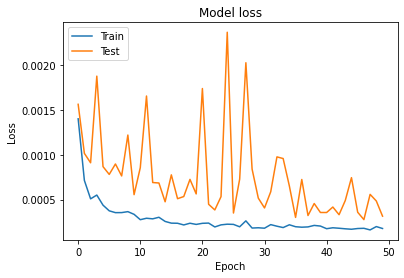

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# test data
test_data = test['Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

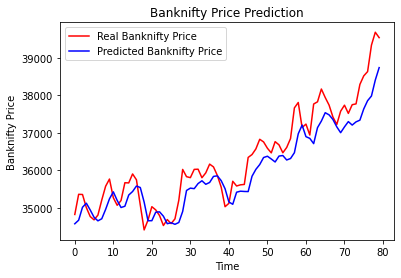

In [13]:
plt.plot(org_y, color = 'red', label = 'Real Banknifty Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Banknifty Price')
plt.title('Banknifty Price Prediction')
plt.xlabel('Time')
plt.ylabel('Banknifty Price')
plt.legend()
plt.show()

In [14]:
import joblib
joblib.dump(scaler, 'scaler.v1.gz')
# my_scaler = joblib.load('scaler.gz')

['scaler.v1.gz']

In [15]:
model.save("lstm_bnf_model.v1.h5")